# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.18886967  1.00606028 -0.2179979  -1.63563519] 0 1.0 True {}
state, action, reward, done, info
[-0.14574561 -0.35778019  0.22252334  0.92276608] 1 1.0 True {}
state, action, reward, done, info
[ 0.17426765  0.40386293 -0.22048101 -0.9594396 ] 0 1.0 True {}
state, action, reward, done, info
[ 0.14530251  1.16922789 -0.21443606 -1.95677233] 1 1.0 True {}
state, action, reward, done, info
[-0.02744856 -0.36528215 -0.21301595 -0.57677263] 1 1.0 True {}
state, action, reward, done, info
[ 0.07665734  0.57508513 -0.22207524 -1.18320415] 1 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            # Given data
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')

            # One hot encode the actions to later choose the Q-value for the action
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            # ReLU hidden layers
            fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None)
                    
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)

            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')

            # error backpropagation: loss and opt
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
train_episodes = 3000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [11]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 0 Total reward: 11.0 Training loss: 1.0777 Explore P: 0.9989
Episode: 1 Total reward: 10.0 Training loss: 1.0576 Explore P: 0.9979
Episode: 2 Total reward: 17.0 Training loss: 1.1921 Explore P: 0.9962
Episode: 3 Total reward: 49.0 Training loss: 1.1926 Explore P: 0.9914
Episode: 4 Total reward: 12.0 Training loss: 1.1982 Explore P: 0.9902
Episode: 5 Total reward: 14.0 Training loss: 1.1708 Explore P: 0.9889
Episode: 6 Total reward: 36.0 Training loss: 1.1061 Explore P: 0.9854
Episode: 7 Total reward: 26.0 Training loss: 1.2711 Explore P: 0.9828
Episode: 8 Total reward: 17.0 Training loss: 1.2107 Explore P: 0.9812
Episode: 9 Total reward: 16.0 Training loss: 1.2460 Explore P: 0.9796
Episode: 10 Total reward: 11.0 Training loss: 1.3364 Explore P: 0.9786
Episode: 11 Total reward: 22.0 Training loss: 1.6516 Explore P: 0.9764
Episode: 12 Total reward: 19.0 Training loss: 1.4554 Explore P: 0.9746
Episode: 13 Total reward: 15.0 Training loss: 1.5113 Explore P: 0.9731
Episode: 14 Tota

Episode: 115 Total reward: 32.0 Training loss: 32.9949 Explore P: 0.8028
Episode: 116 Total reward: 19.0 Training loss: 73.2547 Explore P: 0.8013
Episode: 117 Total reward: 14.0 Training loss: 116.2727 Explore P: 0.8002
Episode: 118 Total reward: 17.0 Training loss: 5.5322 Explore P: 0.7989
Episode: 119 Total reward: 12.0 Training loss: 105.0887 Explore P: 0.7979
Episode: 120 Total reward: 14.0 Training loss: 4.3031 Explore P: 0.7968
Episode: 121 Total reward: 18.0 Training loss: 42.2231 Explore P: 0.7954
Episode: 122 Total reward: 10.0 Training loss: 4.9463 Explore P: 0.7946
Episode: 123 Total reward: 14.0 Training loss: 4.4768 Explore P: 0.7935
Episode: 124 Total reward: 11.0 Training loss: 4.0907 Explore P: 0.7927
Episode: 125 Total reward: 11.0 Training loss: 70.6063 Explore P: 0.7918
Episode: 126 Total reward: 10.0 Training loss: 40.3935 Explore P: 0.7910
Episode: 127 Total reward: 10.0 Training loss: 4.2729 Explore P: 0.7902
Episode: 128 Total reward: 9.0 Training loss: 98.3456 E

Episode: 229 Total reward: 22.0 Training loss: 64.7456 Explore P: 0.6735
Episode: 230 Total reward: 35.0 Training loss: 47.9977 Explore P: 0.6712
Episode: 231 Total reward: 9.0 Training loss: 19.8943 Explore P: 0.6706
Episode: 232 Total reward: 15.0 Training loss: 37.2907 Explore P: 0.6696
Episode: 233 Total reward: 21.0 Training loss: 15.4243 Explore P: 0.6682
Episode: 234 Total reward: 9.0 Training loss: 31.4349 Explore P: 0.6676
Episode: 235 Total reward: 8.0 Training loss: 33.6500 Explore P: 0.6671
Episode: 236 Total reward: 33.0 Training loss: 3.3478 Explore P: 0.6649
Episode: 237 Total reward: 15.0 Training loss: 35.0857 Explore P: 0.6639
Episode: 238 Total reward: 10.0 Training loss: 44.1205 Explore P: 0.6633
Episode: 239 Total reward: 10.0 Training loss: 49.2054 Explore P: 0.6626
Episode: 240 Total reward: 17.0 Training loss: 80.4412 Explore P: 0.6615
Episode: 241 Total reward: 30.0 Training loss: 83.4439 Explore P: 0.6596
Episode: 242 Total reward: 12.0 Training loss: 77.7630 

Episode: 344 Total reward: 22.0 Training loss: 14.4242 Explore P: 0.5299
Episode: 345 Total reward: 13.0 Training loss: 14.3313 Explore P: 0.5293
Episode: 346 Total reward: 12.0 Training loss: 1.5183 Explore P: 0.5286
Episode: 347 Total reward: 18.0 Training loss: 21.8045 Explore P: 0.5277
Episode: 348 Total reward: 24.0 Training loss: 1.4881 Explore P: 0.5265
Episode: 349 Total reward: 38.0 Training loss: 26.4183 Explore P: 0.5245
Episode: 350 Total reward: 22.0 Training loss: 35.5430 Explore P: 0.5234
Episode: 351 Total reward: 8.0 Training loss: 27.3179 Explore P: 0.5230
Episode: 352 Total reward: 54.0 Training loss: 22.2424 Explore P: 0.5202
Episode: 353 Total reward: 12.0 Training loss: 7.2140 Explore P: 0.5196
Episode: 354 Total reward: 16.0 Training loss: 0.9080 Explore P: 0.5188
Episode: 355 Total reward: 50.0 Training loss: 1.1732 Explore P: 0.5162
Episode: 356 Total reward: 27.0 Training loss: 7.6226 Explore P: 0.5149
Episode: 357 Total reward: 13.0 Training loss: 44.7131 Exp

Episode: 457 Total reward: 103.0 Training loss: 3.5996 Explore P: 0.2942
Episode: 458 Total reward: 151.0 Training loss: 207.8579 Explore P: 0.2899
Episode: 459 Total reward: 37.0 Training loss: 51.5968 Explore P: 0.2889
Episode: 460 Total reward: 51.0 Training loss: 2.2494 Explore P: 0.2874
Episode: 461 Total reward: 80.0 Training loss: 1.1295 Explore P: 0.2852
Episode: 462 Total reward: 39.0 Training loss: 1.8067 Explore P: 0.2842
Episode: 463 Total reward: 46.0 Training loss: 1.7901 Explore P: 0.2829
Episode: 464 Total reward: 51.0 Training loss: 127.8824 Explore P: 0.2815
Episode: 465 Total reward: 70.0 Training loss: 3.4006 Explore P: 0.2796
Episode: 466 Total reward: 91.0 Training loss: 41.1212 Explore P: 0.2772
Episode: 467 Total reward: 63.0 Training loss: 48.5907 Explore P: 0.2755
Episode: 468 Total reward: 67.0 Training loss: 25.4573 Explore P: 0.2737
Episode: 469 Total reward: 73.0 Training loss: 46.2862 Explore P: 0.2718
Episode: 470 Total reward: 81.0 Training loss: 0.8488

Episode: 570 Total reward: 122.0 Training loss: 0.5274 Explore P: 0.0791
Episode: 571 Total reward: 154.0 Training loss: 0.4012 Explore P: 0.0780
Episode: 572 Total reward: 130.0 Training loss: 0.3956 Explore P: 0.0771
Episode: 573 Total reward: 151.0 Training loss: 0.5001 Explore P: 0.0761
Episode: 574 Total reward: 199.0 Training loss: 0.2417 Explore P: 0.0748
Episode: 575 Total reward: 139.0 Training loss: 0.2009 Explore P: 0.0739
Episode: 576 Total reward: 124.0 Training loss: 0.2989 Explore P: 0.0731
Episode: 577 Total reward: 176.0 Training loss: 0.3616 Explore P: 0.0720
Episode: 578 Total reward: 199.0 Training loss: 0.4551 Explore P: 0.0708
Episode: 579 Total reward: 161.0 Training loss: 0.9617 Explore P: 0.0698
Episode: 580 Total reward: 152.0 Training loss: 0.4642 Explore P: 0.0689
Episode: 581 Total reward: 132.0 Training loss: 0.3795 Explore P: 0.0682
Episode: 582 Total reward: 181.0 Training loss: 0.8116 Explore P: 0.0671
Episode: 583 Total reward: 178.0 Training loss: 0.2

Episode: 684 Total reward: 41.0 Training loss: 0.7923 Explore P: 0.0259
Episode: 685 Total reward: 36.0 Training loss: 0.9439 Explore P: 0.0258
Episode: 686 Total reward: 115.0 Training loss: 0.8202 Explore P: 0.0257
Episode: 687 Total reward: 109.0 Training loss: 0.9022 Explore P: 0.0255
Episode: 688 Total reward: 152.0 Training loss: 0.2192 Explore P: 0.0252
Episode: 689 Total reward: 132.0 Training loss: 0.4632 Explore P: 0.0250
Episode: 690 Total reward: 199.0 Training loss: 0.5274 Explore P: 0.0248
Episode: 691 Total reward: 113.0 Training loss: 0.5111 Explore P: 0.0246
Episode: 692 Total reward: 199.0 Training loss: 0.2976 Explore P: 0.0243
Episode: 693 Total reward: 199.0 Training loss: 0.3071 Explore P: 0.0240
Episode: 694 Total reward: 199.0 Training loss: 0.7115 Explore P: 0.0237
Episode: 695 Total reward: 199.0 Training loss: 0.8308 Explore P: 0.0235
Episode: 696 Total reward: 199.0 Training loss: 281.9664 Explore P: 0.0232
Episode: 697 Total reward: 199.0 Training loss: 0.4

Episode: 797 Total reward: 199.0 Training loss: 0.5439 Explore P: 0.0134
Episode: 798 Total reward: 199.0 Training loss: 0.9677 Explore P: 0.0133
Episode: 799 Total reward: 199.0 Training loss: 0.5695 Explore P: 0.0133
Episode: 800 Total reward: 150.0 Training loss: 0.4967 Explore P: 0.0132
Episode: 801 Total reward: 117.0 Training loss: 1.2824 Explore P: 0.0132
Episode: 802 Total reward: 114.0 Training loss: 2.6218 Explore P: 0.0131
Episode: 803 Total reward: 33.0 Training loss: 3.0479 Explore P: 0.0131
Episode: 804 Total reward: 26.0 Training loss: 259.1159 Explore P: 0.0131
Episode: 805 Total reward: 27.0 Training loss: 341.6891 Explore P: 0.0131
Episode: 806 Total reward: 35.0 Training loss: 409.5130 Explore P: 0.0131
Episode: 807 Total reward: 28.0 Training loss: 3.4435 Explore P: 0.0131
Episode: 808 Total reward: 29.0 Training loss: 4.3122 Explore P: 0.0131
Episode: 809 Total reward: 23.0 Training loss: 1.5630 Explore P: 0.0131
Episode: 810 Total reward: 25.0 Training loss: 4.787

Episode: 911 Total reward: 13.0 Training loss: 9.9705 Explore P: 0.0126
Episode: 912 Total reward: 13.0 Training loss: 7.9311 Explore P: 0.0126
Episode: 913 Total reward: 9.0 Training loss: 8.9150 Explore P: 0.0126
Episode: 914 Total reward: 10.0 Training loss: 9.5643 Explore P: 0.0126
Episode: 915 Total reward: 9.0 Training loss: 9.1937 Explore P: 0.0126
Episode: 916 Total reward: 13.0 Training loss: 8.1574 Explore P: 0.0126
Episode: 917 Total reward: 12.0 Training loss: 8.4194 Explore P: 0.0126
Episode: 918 Total reward: 13.0 Training loss: 503.8972 Explore P: 0.0126
Episode: 919 Total reward: 15.0 Training loss: 9.4763 Explore P: 0.0126
Episode: 920 Total reward: 11.0 Training loss: 120.9887 Explore P: 0.0126
Episode: 921 Total reward: 11.0 Training loss: 8.5639 Explore P: 0.0126
Episode: 922 Total reward: 12.0 Training loss: 8.1026 Explore P: 0.0126
Episode: 923 Total reward: 15.0 Training loss: 570.8155 Explore P: 0.0126
Episode: 924 Total reward: 12.0 Training loss: 6.9409 Explor

Episode: 1023 Total reward: 199.0 Training loss: 0.3652 Explore P: 0.0107
Episode: 1024 Total reward: 199.0 Training loss: 357.9282 Explore P: 0.0107
Episode: 1025 Total reward: 199.0 Training loss: 0.4053 Explore P: 0.0107
Episode: 1026 Total reward: 199.0 Training loss: 0.2656 Explore P: 0.0107
Episode: 1027 Total reward: 199.0 Training loss: 0.3676 Explore P: 0.0107
Episode: 1028 Total reward: 199.0 Training loss: 0.4184 Explore P: 0.0106
Episode: 1029 Total reward: 199.0 Training loss: 0.1801 Explore P: 0.0106
Episode: 1030 Total reward: 199.0 Training loss: 0.3179 Explore P: 0.0106
Episode: 1031 Total reward: 199.0 Training loss: 0.1528 Explore P: 0.0106
Episode: 1032 Total reward: 199.0 Training loss: 0.5630 Explore P: 0.0106
Episode: 1033 Total reward: 199.0 Training loss: 0.5263 Explore P: 0.0106
Episode: 1034 Total reward: 199.0 Training loss: 0.2760 Explore P: 0.0106
Episode: 1035 Total reward: 199.0 Training loss: 0.4025 Explore P: 0.0106
Episode: 1036 Total reward: 199.0 Tr

Episode: 1134 Total reward: 199.0 Training loss: 0.3370 Explore P: 0.0101
Episode: 1135 Total reward: 199.0 Training loss: 0.3840 Explore P: 0.0101
Episode: 1136 Total reward: 199.0 Training loss: 0.3739 Explore P: 0.0101
Episode: 1137 Total reward: 199.0 Training loss: 0.1933 Explore P: 0.0101
Episode: 1138 Total reward: 199.0 Training loss: 0.2083 Explore P: 0.0101
Episode: 1139 Total reward: 199.0 Training loss: 14.7762 Explore P: 0.0101
Episode: 1140 Total reward: 181.0 Training loss: 0.4401 Explore P: 0.0101
Episode: 1141 Total reward: 199.0 Training loss: 0.1040 Explore P: 0.0101
Episode: 1142 Total reward: 199.0 Training loss: 0.4091 Explore P: 0.0101
Episode: 1143 Total reward: 199.0 Training loss: 0.2973 Explore P: 0.0101
Episode: 1144 Total reward: 199.0 Training loss: 209.9732 Explore P: 0.0101
Episode: 1145 Total reward: 199.0 Training loss: 0.1924 Explore P: 0.0101
Episode: 1146 Total reward: 199.0 Training loss: 0.4195 Explore P: 0.0101
Episode: 1147 Total reward: 199.0 T

Episode: 1245 Total reward: 199.0 Training loss: 0.4031 Explore P: 0.0100
Episode: 1246 Total reward: 199.0 Training loss: 0.3177 Explore P: 0.0100
Episode: 1247 Total reward: 199.0 Training loss: 0.1904 Explore P: 0.0100
Episode: 1248 Total reward: 199.0 Training loss: 0.3769 Explore P: 0.0100
Episode: 1249 Total reward: 199.0 Training loss: 0.5466 Explore P: 0.0100
Episode: 1250 Total reward: 199.0 Training loss: 8.3023 Explore P: 0.0100
Episode: 1251 Total reward: 183.0 Training loss: 0.2742 Explore P: 0.0100
Episode: 1252 Total reward: 199.0 Training loss: 0.3898 Explore P: 0.0100
Episode: 1253 Total reward: 195.0 Training loss: 0.2144 Explore P: 0.0100
Episode: 1254 Total reward: 199.0 Training loss: 0.4110 Explore P: 0.0100
Episode: 1255 Total reward: 199.0 Training loss: 0.4238 Explore P: 0.0100
Episode: 1256 Total reward: 199.0 Training loss: 0.1984 Explore P: 0.0100
Episode: 1257 Total reward: 189.0 Training loss: 0.3938 Explore P: 0.0100
Episode: 1258 Total reward: 199.0 Trai

Episode: 1356 Total reward: 199.0 Training loss: 198.8629 Explore P: 0.0100
Episode: 1357 Total reward: 199.0 Training loss: 0.3463 Explore P: 0.0100
Episode: 1358 Total reward: 199.0 Training loss: 0.1372 Explore P: 0.0100
Episode: 1359 Total reward: 199.0 Training loss: 0.1458 Explore P: 0.0100
Episode: 1360 Total reward: 199.0 Training loss: 0.4677 Explore P: 0.0100
Episode: 1361 Total reward: 199.0 Training loss: 0.1879 Explore P: 0.0100
Episode: 1362 Total reward: 199.0 Training loss: 0.3649 Explore P: 0.0100
Episode: 1363 Total reward: 199.0 Training loss: 0.2397 Explore P: 0.0100
Episode: 1364 Total reward: 199.0 Training loss: 0.2629 Explore P: 0.0100
Episode: 1365 Total reward: 199.0 Training loss: 0.2510 Explore P: 0.0100
Episode: 1366 Total reward: 199.0 Training loss: 0.2332 Explore P: 0.0100
Episode: 1367 Total reward: 199.0 Training loss: 0.2633 Explore P: 0.0100
Episode: 1368 Total reward: 199.0 Training loss: 0.3155 Explore P: 0.0100
Episode: 1369 Total reward: 199.0 Tr

Episode: 1467 Total reward: 199.0 Training loss: 0.1842 Explore P: 0.0100
Episode: 1468 Total reward: 199.0 Training loss: 0.1136 Explore P: 0.0100
Episode: 1469 Total reward: 199.0 Training loss: 0.1949 Explore P: 0.0100
Episode: 1470 Total reward: 199.0 Training loss: 0.2232 Explore P: 0.0100
Episode: 1471 Total reward: 199.0 Training loss: 0.1645 Explore P: 0.0100
Episode: 1472 Total reward: 199.0 Training loss: 14.6097 Explore P: 0.0100
Episode: 1473 Total reward: 199.0 Training loss: 0.2053 Explore P: 0.0100
Episode: 1474 Total reward: 199.0 Training loss: 0.2487 Explore P: 0.0100
Episode: 1475 Total reward: 199.0 Training loss: 0.1759 Explore P: 0.0100
Episode: 1476 Total reward: 199.0 Training loss: 0.1300 Explore P: 0.0100
Episode: 1477 Total reward: 199.0 Training loss: 0.1244 Explore P: 0.0100
Episode: 1478 Total reward: 199.0 Training loss: 0.2401 Explore P: 0.0100
Episode: 1479 Total reward: 199.0 Training loss: 0.0681 Explore P: 0.0100
Episode: 1480 Total reward: 199.0 Tra

Episode: 1578 Total reward: 199.0 Training loss: 0.1268 Explore P: 0.0100
Episode: 1579 Total reward: 199.0 Training loss: 0.2575 Explore P: 0.0100
Episode: 1580 Total reward: 199.0 Training loss: 365.9785 Explore P: 0.0100
Episode: 1581 Total reward: 199.0 Training loss: 0.6472 Explore P: 0.0100
Episode: 1582 Total reward: 199.0 Training loss: 178.9483 Explore P: 0.0100
Episode: 1583 Total reward: 199.0 Training loss: 0.1647 Explore P: 0.0100
Episode: 1584 Total reward: 199.0 Training loss: 0.2309 Explore P: 0.0100
Episode: 1585 Total reward: 199.0 Training loss: 0.2200 Explore P: 0.0100
Episode: 1586 Total reward: 199.0 Training loss: 0.2723 Explore P: 0.0100
Episode: 1587 Total reward: 199.0 Training loss: 0.0934 Explore P: 0.0100
Episode: 1588 Total reward: 199.0 Training loss: 0.3759 Explore P: 0.0100
Episode: 1589 Total reward: 199.0 Training loss: 165.6745 Explore P: 0.0100
Episode: 1590 Total reward: 199.0 Training loss: 0.1640 Explore P: 0.0100
Episode: 1591 Total reward: 199.

Episode: 1693 Total reward: 12.0 Training loss: 2.8687 Explore P: 0.0100
Episode: 1694 Total reward: 13.0 Training loss: 4.0038 Explore P: 0.0100
Episode: 1695 Total reward: 17.0 Training loss: 607.4274 Explore P: 0.0100
Episode: 1696 Total reward: 11.0 Training loss: 2.1578 Explore P: 0.0100
Episode: 1697 Total reward: 199.0 Training loss: 1.2740 Explore P: 0.0100
Episode: 1698 Total reward: 199.0 Training loss: 340.9516 Explore P: 0.0100
Episode: 1699 Total reward: 7.0 Training loss: 4.3541 Explore P: 0.0100
Episode: 1700 Total reward: 7.0 Training loss: 2.9465 Explore P: 0.0100
Episode: 1701 Total reward: 12.0 Training loss: 5.3512 Explore P: 0.0100
Episode: 1702 Total reward: 10.0 Training loss: 323.3556 Explore P: 0.0100
Episode: 1703 Total reward: 9.0 Training loss: 966.7198 Explore P: 0.0100
Episode: 1704 Total reward: 8.0 Training loss: 5.7686 Explore P: 0.0100
Episode: 1705 Total reward: 10.0 Training loss: 502.1790 Explore P: 0.0100
Episode: 1706 Total reward: 12.0 Training l

Episode: 1805 Total reward: 199.0 Training loss: 0.9220 Explore P: 0.0100
Episode: 1806 Total reward: 199.0 Training loss: 0.3648 Explore P: 0.0100
Episode: 1807 Total reward: 199.0 Training loss: 0.4354 Explore P: 0.0100
Episode: 1808 Total reward: 199.0 Training loss: 0.7150 Explore P: 0.0100
Episode: 1809 Total reward: 199.0 Training loss: 1.1340 Explore P: 0.0100
Episode: 1810 Total reward: 199.0 Training loss: 5.2763 Explore P: 0.0100
Episode: 1811 Total reward: 199.0 Training loss: 393.8909 Explore P: 0.0100
Episode: 1812 Total reward: 199.0 Training loss: 0.5318 Explore P: 0.0100
Episode: 1813 Total reward: 199.0 Training loss: 0.4503 Explore P: 0.0100
Episode: 1814 Total reward: 199.0 Training loss: 0.1346 Explore P: 0.0100
Episode: 1815 Total reward: 199.0 Training loss: 0.8988 Explore P: 0.0100
Episode: 1816 Total reward: 199.0 Training loss: 0.5797 Explore P: 0.0100
Episode: 1817 Total reward: 199.0 Training loss: 250.7243 Explore P: 0.0100
Episode: 1818 Total reward: 199.0 

Episode: 1916 Total reward: 199.0 Training loss: 0.0811 Explore P: 0.0100
Episode: 1917 Total reward: 199.0 Training loss: 0.2182 Explore P: 0.0100
Episode: 1918 Total reward: 199.0 Training loss: 0.1555 Explore P: 0.0100
Episode: 1919 Total reward: 199.0 Training loss: 0.1139 Explore P: 0.0100
Episode: 1920 Total reward: 199.0 Training loss: 0.1007 Explore P: 0.0100
Episode: 1921 Total reward: 199.0 Training loss: 0.2196 Explore P: 0.0100
Episode: 1922 Total reward: 199.0 Training loss: 0.3444 Explore P: 0.0100
Episode: 1923 Total reward: 199.0 Training loss: 0.0706 Explore P: 0.0100
Episode: 1924 Total reward: 199.0 Training loss: 0.1892 Explore P: 0.0100
Episode: 1925 Total reward: 199.0 Training loss: 0.1361 Explore P: 0.0100
Episode: 1926 Total reward: 199.0 Training loss: 0.0845 Explore P: 0.0100
Episode: 1927 Total reward: 199.0 Training loss: 0.0908 Explore P: 0.0100
Episode: 1928 Total reward: 199.0 Training loss: 0.1126 Explore P: 0.0100
Episode: 1929 Total reward: 199.0 Trai

Episode: 2027 Total reward: 199.0 Training loss: 0.0679 Explore P: 0.0100
Episode: 2028 Total reward: 199.0 Training loss: 0.1131 Explore P: 0.0100
Episode: 2029 Total reward: 199.0 Training loss: 0.1890 Explore P: 0.0100
Episode: 2030 Total reward: 199.0 Training loss: 0.1913 Explore P: 0.0100
Episode: 2031 Total reward: 199.0 Training loss: 0.1636 Explore P: 0.0100
Episode: 2032 Total reward: 199.0 Training loss: 0.0843 Explore P: 0.0100
Episode: 2033 Total reward: 199.0 Training loss: 0.1091 Explore P: 0.0100
Episode: 2034 Total reward: 199.0 Training loss: 0.1624 Explore P: 0.0100
Episode: 2035 Total reward: 199.0 Training loss: 0.1645 Explore P: 0.0100
Episode: 2036 Total reward: 199.0 Training loss: 0.0645 Explore P: 0.0100
Episode: 2037 Total reward: 199.0 Training loss: 0.1199 Explore P: 0.0100
Episode: 2038 Total reward: 199.0 Training loss: 64.9613 Explore P: 0.0100
Episode: 2039 Total reward: 199.0 Training loss: 0.0691 Explore P: 0.0100
Episode: 2040 Total reward: 199.0 Tra

Episode: 2138 Total reward: 199.0 Training loss: 0.1320 Explore P: 0.0100
Episode: 2139 Total reward: 199.0 Training loss: 0.1262 Explore P: 0.0100
Episode: 2140 Total reward: 199.0 Training loss: 49.0525 Explore P: 0.0100
Episode: 2141 Total reward: 199.0 Training loss: 0.3435 Explore P: 0.0100
Episode: 2142 Total reward: 199.0 Training loss: 0.2224 Explore P: 0.0100
Episode: 2143 Total reward: 199.0 Training loss: 0.2588 Explore P: 0.0100
Episode: 2144 Total reward: 199.0 Training loss: 0.2233 Explore P: 0.0100
Episode: 2145 Total reward: 199.0 Training loss: 0.3164 Explore P: 0.0100
Episode: 2146 Total reward: 199.0 Training loss: 0.4774 Explore P: 0.0100
Episode: 2147 Total reward: 199.0 Training loss: 0.1827 Explore P: 0.0100
Episode: 2148 Total reward: 199.0 Training loss: 0.1556 Explore P: 0.0100
Episode: 2149 Total reward: 199.0 Training loss: 0.5076 Explore P: 0.0100
Episode: 2150 Total reward: 199.0 Training loss: 0.1827 Explore P: 0.0100
Episode: 2151 Total reward: 199.0 Tra

Episode: 2249 Total reward: 199.0 Training loss: 0.3041 Explore P: 0.0100
Episode: 2250 Total reward: 199.0 Training loss: 0.1299 Explore P: 0.0100
Episode: 2251 Total reward: 199.0 Training loss: 0.0632 Explore P: 0.0100
Episode: 2252 Total reward: 199.0 Training loss: 0.1496 Explore P: 0.0100
Episode: 2253 Total reward: 199.0 Training loss: 31.9946 Explore P: 0.0100
Episode: 2254 Total reward: 199.0 Training loss: 0.1099 Explore P: 0.0100
Episode: 2255 Total reward: 199.0 Training loss: 0.1344 Explore P: 0.0100
Episode: 2256 Total reward: 199.0 Training loss: 0.2917 Explore P: 0.0100
Episode: 2257 Total reward: 199.0 Training loss: 0.1581 Explore P: 0.0100
Episode: 2258 Total reward: 199.0 Training loss: 37.8303 Explore P: 0.0100
Episode: 2259 Total reward: 199.0 Training loss: 241.0648 Explore P: 0.0100
Episode: 2260 Total reward: 199.0 Training loss: 0.1131 Explore P: 0.0100
Episode: 2261 Total reward: 199.0 Training loss: 0.3244 Explore P: 0.0100
Episode: 2262 Total reward: 199.0 

Episode: 2360 Total reward: 199.0 Training loss: 62.0235 Explore P: 0.0100
Episode: 2361 Total reward: 199.0 Training loss: 0.1591 Explore P: 0.0100
Episode: 2362 Total reward: 199.0 Training loss: 0.1976 Explore P: 0.0100
Episode: 2363 Total reward: 199.0 Training loss: 0.1363 Explore P: 0.0100
Episode: 2364 Total reward: 199.0 Training loss: 0.1577 Explore P: 0.0100
Episode: 2365 Total reward: 199.0 Training loss: 0.1489 Explore P: 0.0100
Episode: 2366 Total reward: 199.0 Training loss: 0.0786 Explore P: 0.0100
Episode: 2367 Total reward: 199.0 Training loss: 0.1333 Explore P: 0.0100
Episode: 2368 Total reward: 199.0 Training loss: 0.1419 Explore P: 0.0100
Episode: 2369 Total reward: 199.0 Training loss: 0.2507 Explore P: 0.0100
Episode: 2370 Total reward: 199.0 Training loss: 0.2164 Explore P: 0.0100
Episode: 2371 Total reward: 199.0 Training loss: 0.0778 Explore P: 0.0100
Episode: 2372 Total reward: 199.0 Training loss: 0.1242 Explore P: 0.0100
Episode: 2373 Total reward: 199.0 Tra

Episode: 2471 Total reward: 199.0 Training loss: 0.0957 Explore P: 0.0100
Episode: 2472 Total reward: 199.0 Training loss: 0.0697 Explore P: 0.0100
Episode: 2473 Total reward: 159.0 Training loss: 0.0744 Explore P: 0.0100
Episode: 2474 Total reward: 167.0 Training loss: 0.0849 Explore P: 0.0100
Episode: 2475 Total reward: 156.0 Training loss: 0.1501 Explore P: 0.0100
Episode: 2476 Total reward: 183.0 Training loss: 0.1249 Explore P: 0.0100
Episode: 2477 Total reward: 177.0 Training loss: 0.0624 Explore P: 0.0100
Episode: 2478 Total reward: 164.0 Training loss: 0.1708 Explore P: 0.0100
Episode: 2479 Total reward: 145.0 Training loss: 11.4470 Explore P: 0.0100
Episode: 2480 Total reward: 178.0 Training loss: 26.7629 Explore P: 0.0100
Episode: 2481 Total reward: 199.0 Training loss: 16.6178 Explore P: 0.0100
Episode: 2482 Total reward: 197.0 Training loss: 0.0620 Explore P: 0.0100
Episode: 2483 Total reward: 188.0 Training loss: 0.1098 Explore P: 0.0100
Episode: 2484 Total reward: 199.0 T

Episode: 2584 Total reward: 54.0 Training loss: 264.4914 Explore P: 0.0100
Episode: 2585 Total reward: 34.0 Training loss: 5.5369 Explore P: 0.0100
Episode: 2586 Total reward: 39.0 Training loss: 1.2967 Explore P: 0.0100
Episode: 2587 Total reward: 16.0 Training loss: 0.4200 Explore P: 0.0100
Episode: 2588 Total reward: 45.0 Training loss: 1.5966 Explore P: 0.0100
Episode: 2589 Total reward: 116.0 Training loss: 3.1248 Explore P: 0.0100
Episode: 2590 Total reward: 136.0 Training loss: 0.8078 Explore P: 0.0100
Episode: 2591 Total reward: 199.0 Training loss: 1.3915 Explore P: 0.0100
Episode: 2592 Total reward: 199.0 Training loss: 0.9336 Explore P: 0.0100
Episode: 2593 Total reward: 199.0 Training loss: 0.5118 Explore P: 0.0100
Episode: 2594 Total reward: 199.0 Training loss: 0.8400 Explore P: 0.0100
Episode: 2595 Total reward: 199.0 Training loss: 0.4839 Explore P: 0.0100
Episode: 2596 Total reward: 199.0 Training loss: 1.1367 Explore P: 0.0100
Episode: 2597 Total reward: 199.0 Trainin

Episode: 2695 Total reward: 199.0 Training loss: 0.0974 Explore P: 0.0100
Episode: 2696 Total reward: 199.0 Training loss: 0.0674 Explore P: 0.0100
Episode: 2697 Total reward: 199.0 Training loss: 0.1475 Explore P: 0.0100
Episode: 2698 Total reward: 199.0 Training loss: 0.0770 Explore P: 0.0100
Episode: 2699 Total reward: 199.0 Training loss: 71.0032 Explore P: 0.0100
Episode: 2700 Total reward: 199.0 Training loss: 0.1389 Explore P: 0.0100
Episode: 2701 Total reward: 199.0 Training loss: 0.0634 Explore P: 0.0100
Episode: 2702 Total reward: 199.0 Training loss: 0.0784 Explore P: 0.0100
Episode: 2703 Total reward: 199.0 Training loss: 0.0698 Explore P: 0.0100
Episode: 2704 Total reward: 199.0 Training loss: 0.0764 Explore P: 0.0100
Episode: 2705 Total reward: 199.0 Training loss: 0.0786 Explore P: 0.0100
Episode: 2706 Total reward: 199.0 Training loss: 0.3786 Explore P: 0.0100
Episode: 2707 Total reward: 199.0 Training loss: 29.4835 Explore P: 0.0100
Episode: 2708 Total reward: 199.0 Tr

Episode: 2806 Total reward: 199.0 Training loss: 252.3097 Explore P: 0.0100
Episode: 2807 Total reward: 199.0 Training loss: 0.2614 Explore P: 0.0100
Episode: 2808 Total reward: 199.0 Training loss: 0.4110 Explore P: 0.0100
Episode: 2809 Total reward: 199.0 Training loss: 0.2001 Explore P: 0.0100
Episode: 2810 Total reward: 199.0 Training loss: 0.1640 Explore P: 0.0100
Episode: 2811 Total reward: 199.0 Training loss: 0.4306 Explore P: 0.0100
Episode: 2812 Total reward: 199.0 Training loss: 0.2915 Explore P: 0.0100
Episode: 2813 Total reward: 199.0 Training loss: 0.1306 Explore P: 0.0100
Episode: 2814 Total reward: 199.0 Training loss: 216.5782 Explore P: 0.0100
Episode: 2815 Total reward: 199.0 Training loss: 0.2537 Explore P: 0.0100
Episode: 2816 Total reward: 199.0 Training loss: 0.3210 Explore P: 0.0100
Episode: 2817 Total reward: 199.0 Training loss: 0.2676 Explore P: 0.0100
Episode: 2818 Total reward: 199.0 Training loss: 0.3135 Explore P: 0.0100
Episode: 2819 Total reward: 199.0 

Episode: 2917 Total reward: 199.0 Training loss: 0.2682 Explore P: 0.0100
Episode: 2918 Total reward: 199.0 Training loss: 0.2028 Explore P: 0.0100
Episode: 2919 Total reward: 199.0 Training loss: 0.2270 Explore P: 0.0100
Episode: 2920 Total reward: 199.0 Training loss: 0.1862 Explore P: 0.0100
Episode: 2921 Total reward: 199.0 Training loss: 127.7215 Explore P: 0.0100
Episode: 2922 Total reward: 199.0 Training loss: 0.2613 Explore P: 0.0100
Episode: 2923 Total reward: 199.0 Training loss: 0.3711 Explore P: 0.0100
Episode: 2924 Total reward: 199.0 Training loss: 0.1948 Explore P: 0.0100
Episode: 2925 Total reward: 199.0 Training loss: 0.4114 Explore P: 0.0100
Episode: 2926 Total reward: 199.0 Training loss: 0.2893 Explore P: 0.0100
Episode: 2927 Total reward: 199.0 Training loss: 0.2252 Explore P: 0.0100
Episode: 2928 Total reward: 199.0 Training loss: 0.2297 Explore P: 0.0100
Episode: 2929 Total reward: 199.0 Training loss: 0.3253 Explore P: 0.0100
Episode: 2930 Total reward: 199.0 Tr

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

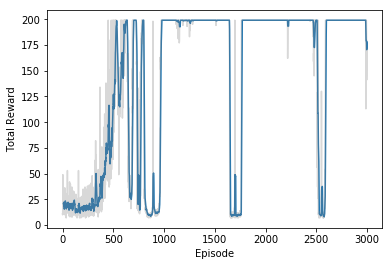

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.